In the NFL, the quarterback is the most important position on the field. The quarterback is responsible for leading the offense and making important decisions that can have a significant impact on the outcome of a game. In the NFL, where the margins between winning and losing are often slim, the ability of a quarterback to perform at a high level can be the difference between a successful season and a disappointing one. 

One of the key ways to evaluate quarterback play is through statistical analysis. This can include metrics such as passer rating, yards per attempt, touchdown-to-interception ratio, and completion percentage, among others. These statistics can provide valuable insights into a quarterback's performance and can help to identify strengths and weaknesses. For our project, we are focusing on the evaluation of quarterback play in the NFL. Our goal is to plot each NFL quarterback on a chart that allows us to easily evaluate how they stack up to their peers in important metrics in a visual way. Another insight we want to gain is if there is any correlation between the age of a quarterback and their value to their team. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import pandas as pd
from math import pi
import numpy as np
from sklearn.metrics import r2_score

Data Collection, Curating, Management, Representation

The first step is the data collection process, in which we gather the data we need for our analysis. In our case we are getting passing and rushing data about NFL players from the Pro Football Reference website, specifically for the 2021 season. We collect this data using the read_html function of Pandas. We store the passing and rushing data separately into passing and rushing Pandas Dataframes. 

In [ ]:
passing = pd.read_html("https://www.pro-football-reference.com/years/2021/passing.htm")[0]
rushing = pd.read_html("https://www.pro-football-reference.com/years/2021/rushing.htm")[0]

passing = passing.drop(columns=['Cmp', 'Yds', 'TD', 'Int', 'Rk', 'Tm', 'Pos', 'G', 'GS', 'QBrec', '1D', 'Lng', 'Y/G', 'AY/A', 'Rate', 'QBR', 'Sk', 'Yds.1', 'Sk%', 'NY/A', 'ANY/A', '4QC', 'GWD'])

The next step in the process is data cleaning, in which we remove irrelevant or faulty data and make sure that it is ready for analysis. Ways we cleaned the data include removing wrongly formatted values and normalizing the data. Also as part of the process we had to handle data management and representation. Ways we handled this include storing data from different sources in a single dataframe, creating our own columns for analysis, and removing irrelevant columns. 

The first step in cleaning the data is to iterate through the passing dataframe and format the players’ names. Then, as part of data management and representation, we drop all players with less than 200 pass attempts, which gives us 33 quarterbacks to evaluate. 


In [ ]:

for index, row in passing.iterrows():

    name = passing.at[index,"Player"]
    name1="".join(ch for ch in name if ch.isalnum() or ch == ' ')
    passing.at[index,"Player"] = name1

    y = passing.at[index,"Att"]
    if (y == "Att") or (int(y) < 200):
      passing = passing.drop([index])

We then add rushing statistics to our passing dataframe, so we can combine both dataframes into one. For each player in the rushing dataset, we add their rushing data to the entry in the passing dataset that matches their name. This gives us a single dataframe with all of the data we need to evaluate the quarterbacks. We will still need to add and drop some columns, however.


In [ ]:
passing = passing.drop(columns=['Att'])
passing['RushAtt'] = 0
passing['RushYds'] = 0
passing['Fum'] = 0
for index, row in passing.iterrows(): 
    for x, y in rushing.iterrows():

      name = rushing.at[x,('Unnamed: 1_level_0', 'Player')]
      name1="".join(ch for ch in name if ch.isalnum() or ch == ' ')
      name = passing.at[index,"Player"]

      if name == name1:
        r = rushing.at[x, (            'Rushing',    'Att')]
        if r != "Att": passing.at[index, "RushAtt"] = r

        r = rushing.at[x, (            'Rushing',    'Yds')]
        if r != "Yds": passing.at[index, "RushYds"] = r

        r = rushing.at[x, ('Unnamed: 14_level_0',    'Fmb')]
        if r != "Fmb": passing.at[index, "Fum"] = r

        break

For each entry in the dataframe, we calculate the value for new columns (rushing yards per attempt and fumble per attempt) using the existing columns in the dataframe. We also convert each of the percentage columns to float values, which makes analysis of the data easier. After this, we can drop the columns that we used to calculate the new columns since we do not need them anymore.


In [ ]:
passing['Ryd/A'] = 0.0
passing['Fum/A'] = 0.0

for index, row in passing.iterrows():
  r_att = int(passing.at[index,"RushAtt"])
  r_yds = int(passing.at[index,"RushYds"])
  r_fum = int(passing.at[index,"Fum"])

  passing.at[index, 'Ryd/A'] = round(r_yds/r_att, 1)
  passing.at[index, 'Fum/A'] = round(r_fum/r_att, 1)
  passing.at[index, "Cmp%"] = float(passing.at[index, "Cmp%"])
  passing.at[index, "TD%"] = float(passing.at[index, "TD%"])
  passing.at[index, "Int%"] = float(passing.at[index, "Int%"])
  passing.at[index, "Y/A"] = float(passing.at[index, "Y/A"])
  passing.at[index, "Age"] = float(passing.at[index, "Age"])


passing = passing.drop(columns=['RushAtt'])
passing = passing.drop(columns=['RushYds'])
passing = passing.drop(columns=['Fum'])

We have good data for each quarterback to evaluate them, but they are all on different scales. For example, completion percentage may be in the 60’s while quarterback while yards per attempt is in the single digits. We are going to be plotting the quarterbacks on pizza charts, and such different scales for the columns will skew our charts. To fix this issue we have to normalize the columns so that they hold similar values even though they refer to different metrics. 

Our approach was to calculate the percentile that each quarterback was in for each metric. This allows us to more easily compare each quarterback to their peers for each metric while also giving the same scale for all the metrics, which helps make the pizza chart more informative. 

We create new columns for percentiles for each column, then generate sorted lists for each column. This list allows us to calculate the percentile for any value in a column. We then iterate through the dataframe and for each column’s value, we calculate its percentile in its column using the lists and set the corresponding percentile column. After this we can drop the original columns, as all we need are the percentiles.

Other approaches other than setting percentiles are normalizing the columns so they have the same or similar means. This approach also works for removing skew from the pizza charts. However, we prefer setting to percentiles because it is better at giving us an idea of how each quarterback performs compared to his peers. 

For help calculating the percentile for each value we used the following resource: https://www.thoughtco.com/what-is-a-percentile-3126238#:~:text=Percentiles%20can%20be%20calculated%20using,rank%20of%20a%20given%20value.&text=Percentiles%20are%20frequently%20used%20to%20understand%20test%20scores%20and%20biometric%20measurements.

In [ ]:
passing['cmp_p'] = 0.0
passing['td_p'] = 0.0
passing['int_p'] = 0.0
passing['y/a_p'] = 0.0
passing['ryd/a_p'] = 0.0
passing['fum/a_p'] = 0.0

cmpp = sorted(passing.loc[:,"Cmp%"].tolist())
tdp = sorted(passing.loc[:, "TD%"].tolist())
intp = sorted(passing.loc[:,"Int%"].tolist())
yap = sorted(passing.loc[:, "Y/A"].tolist())
rydap = sorted(passing.loc[:,"Ryd/A"].tolist())
fumap = sorted(passing.loc[:, "Fum/A"].tolist())

for index, row in passing.iterrows():
  passing.at[index, 'cmp_p'] = round((((cmpp.index(passing.at[index, "Cmp%"])) + 1)/33)*100, 2)
  passing.at[index, 'td_p'] = round((((tdp.index(passing.at[index, "TD%"])) + 1)/33)*100, 2)
  passing.at[index, 'int_p'] = round((((intp.index(passing.at[index, "Int%"])) + 1)/33)*100, 2)
  passing.at[index, 'y/a_p'] = round((((yap.index(passing.at[index, "Y/A"])) + 1)/33)*100, 2)
  passing.at[index, 'ryd/a_p'] = round((((rydap.index(passing.at[index, "Ryd/A"])) + 1)/33)*100, 2)
  passing.at[index, 'fum/a_p'] = round((((fumap.index(passing.at[index, "Fum/A"])) + 1)/33)*100, 2)

passing = passing.drop(columns=['Cmp%', 'TD%', 'Int%', 'Y/A', 'Y/C', 'Ryd/A', 'Fum/A'])

print(passing)

                Player   Age   cmp_p    td_p   int_p   y/a_p  ryd/a_p  fum/a_p
0            Tom Brady  44.0   75.76   84.85   21.21   63.64    21.21    12.12
1       Justin Herbert  23.0   48.48   78.79   48.48   69.70    63.64     3.03
2     Matthew Stafford  33.0   66.67   96.97   75.76   93.94     6.06    51.52
3      Patrick Mahomes  26.0   51.52   72.73   36.36   63.64    87.88    12.12
4           Derek Carr  30.0   87.88   30.30   48.48   81.82    18.18    78.79
5           Joe Burrow  25.0  100.00   93.94   69.70  100.00    27.27    12.12
6         Dak Prescott  28.0   90.91   87.88   21.21   69.70    27.27    78.79
7           Josh Allen  25.0   30.30   72.73   54.55   27.27    96.97    12.12
8         Kirk Cousins  33.0   51.52   81.82    6.06   69.70    51.52    93.94
9        Aaron Rodgers  38.0   93.94  100.00    3.03   81.82    36.36    12.12
10           Matt Ryan  36.0   63.64   24.24   39.39   48.48    12.12    78.79
11     Jimmy Garoppolo  30.0   84.85   63.64   69.70

Data Analysis

For data analysis we want to gain insights from the data that we have obtained. We want to find trends or test hypotheses using statistical tools like charts or models.

With the percentile columns, we are able to plot the pizza charts for each quarterback. The charts give us an easy visual way to tell how they compare to other quarterbacks, especially since the values for the metrics are based on percentile. For example, from a quick glance we can see Joe Burrow is a very strong quarterback as he almost fills the chart for metrics such as touchdown percentage and completion percentage, while having low ranks for negative metrics like fumbles per rushing attempt. On the other side, we can see Jacoby Brissett covers a low area of the pie chart for positive metrics while having a high rank for negative metrics like fumbles per rush attempt. We do not need look at multiple graphs of different players to tell how a player compares to his peers, since the area covered in the pizza chart is based on the percentile values. Thus even without looking at other players’ graphs we can make the same conclusions about players like Joe Burrow and Jacoby Brissett as mentioned earlier.

For help creating the pizza charts, we used the following resource: https://stackoverflow.com/questions/62938954/pie-radar-chart-in-python-pizza-slices. 

In [ ]:
categories = ['Completion %', 'TD %', 'Int %', 'Yards/Attempt', 'Rush Yards/Attempt', 'Fumbles/Rush Attempt']
colors = ['r', 'b', 'g']

N = len(categories)
angles = np.linspace(0, 2 * pi, N, endpoint=False)
angles_mids = angles + (angles[1] / 2)


for index, row in passing.iterrows():
  fig = plt.figure(figsize=(6, 6))
  ax = plt.subplot(111, polar=True)
  ax.set_theta_offset(pi / 2)
  ax.set_theta_direction(-1)
  ax.set_xticks(angles_mids)
  ax.set_xticklabels(categories)
  ax.xaxis.set_minor_locator(FixedLocator(angles))

  ax.set_rlabel_position(0)
  ax.set_yticks([20, 40, 60, 80, 100])
  ax.set_yticklabels(["20", "40", "60", "80", "100"], color="black", size=8)
  ax.set_ylim(0, 100)

  values = [passing.at[index, "cmp_p"], passing.at[index, "td_p"], passing.at[index, "int_p"], passing.at[index, "y/a_p"], passing.at[index, "ryd/a_p"], passing.at[index, "fum/a_p"]]

  ax.bar(angles_mids, values, width=angles[1] - angles[0], label=passing.at[index, "Player"], facecolor=colors[index%3], alpha=0.7, edgecolor='k', linewidth=1)

  ax.grid(True, axis='x', which='minor')
  ax.grid(False, axis='x', which='major')
  ax.grid(True, axis='y', which='major')
  ax.legend(loc='upper left', bbox_to_anchor=(0.9, 1))
  plt.show()



Output hidden; open in https://colab.research.google.com to view.

Hypothesis Testing

We continue to do some more data analysis with hypothesis testing based on age and quarterback value. We test the hypothesis that quarterback performance decreases with age, and see if there is any correlation between the age of a quarterback and their value to their team. For this we set weights for each statistic of the quarterbacks, such as rushing yards and touchdowns. We tried to weigh the most important statistics with higher coefficients. After calculating a value for each quarterback based on these coefficients, we plotted each quarterback’s age against their calculated value and put it on a scatterplot. We then ran a linear regression model. What we found is that there is little correlation. Both old and young quarterbacks were found on the low-value and high-value ends of the graph. We attempted to fit a linear regression model to the data and got a very low value for r^2: 0.0162. Thus we find the hypothesis to be false.

We used sklearn linear regression for this analysis, which you can learn more about at https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html. 


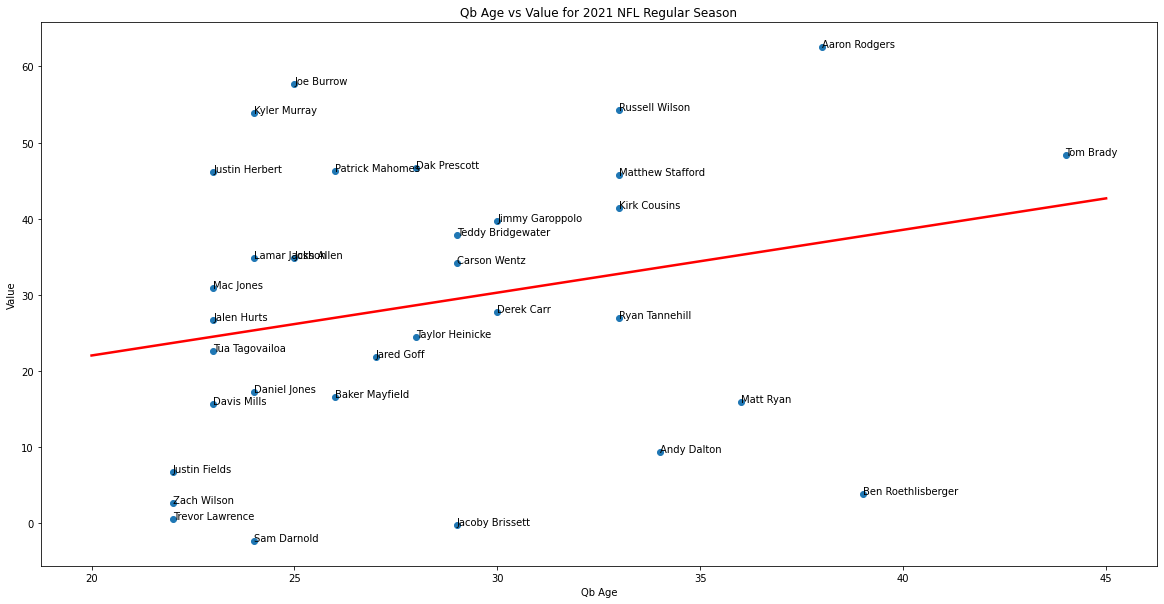

In [ ]:
player_value = []
player = []
age = []

for index, row in passing.iterrows():
  completion = passing.at[index, "cmp_p"]
  touchdowns = passing.at[index, "td_p"]
  interception = passing.at[index, "int_p"]
  yards = passing.at[index, "y/a_p"]
  rushyards = passing.at[index, "ryd/a_p"]
  fumbles = passing.at[index, "fum/a_p"]

  v = 0.15*completion + 0.30*touchdowns + 0.20*yards + 0.1*rushyards - 0.1*fumbles - 0.1*interception

  player_value.append(v)
  player.append(passing.at[index, "Player"])
  age.append(passing.at[index, "Age"])


plt.figure(figsize=(20,10))
plt.scatter(age, player_value)

plt.xlabel('Qb Age')
plt.ylabel('Value')
plt.title("Qb Age vs Value for 2021 NFL Regular Season")

b, a = np.polyfit(age, player_value, deg=1)
xseq = np.linspace(20, 45, num=100)
plt.plot(xseq, a + b * xseq, color="Red", lw=2.5);

for i, label in enumerate(player):
    plt.annotate(label, (age[i], player_value[i]))

plt.show()

In [ ]:
age_average = {}
age_pred = {}

for i in range(0, len(age)):
  x = age[i]
  if x in age_average.keys():
    age_average[x]= age_average[x] + int(player_value[i])
  else:
    age_average[x] = int(player_value[i])
  
  if x not in age_pred.keys():
    age_pred[x] = a + b * x

actual = []
pred = []

for i in age_pred.keys():
  pred.append(age_pred[i])
  actual.append(age_average[i]/age.count(i))

r2 = r2_score(actual, pred)

print("Coefficient of Determination is: " + str(r2))


Coefficient of Determination is: 0.016181694366227628


Communication of Insights

In communication of insights we want to show what information we have gained from our data analysis. 

One insight we found from our data analysis is that players who cover a high area on the pizza charts (except for negative metrics) can be considered more valuable players. This makes sense as the higher percentile the players were in positive metrics, the more area they would take on the charts for those metrics. We found many of the consensus top players in the league had high areas on their charts, which matched the perception of them.

Another insight we found is that there is little correlation between age and value to the team for quarterbacks. We could explain this with the fact that there are many different situations for quarterbacks in relation to their ages. Older quarterbacks who still have a high value have high experience and thus can be very valuable to their team, while on the flip side other older quarterbacks could be well past their prime and starting to slow down athletically, dragging down their value to their teams. For the younger players, some of them may be inexperienced and thus have low values for their team, but are still played so that they can develop into strong players. Other young quarterbacks who are more developed are in their athletic prime and are thus in a good position to offer high value to their team. With all of these different situations, we can find old and young quarterbacks at any position in the graph, and it is hard to find a correlation between age and value. Thus we find that the hypothesis that quarterback value goes down with age is false. 
